# Transshipments

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pycountry

In [22]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
color = sns.color_palette("tab10", 10)[0]

In [3]:
wd = "/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/"

In [188]:
carrier = pd.read_excel(wd + 'port_evaluation/data/proc/GFW/gfw_data-v2.xlsx', sheet_name='carriers')
loiter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/loitering.csv')
encounter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/encounter.csv')
port_visit = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')

In [19]:
encounter = pd.read_csv(wd + 'pipeline/data/local/encounter.csv')
encounter['distance_from_shore_nm'] = encounter['distance_from_shore_m'] / 1852
encounter['encounter.authorization_status'].value_counts()

unknown       33318
partial       13649
authorized     9908
pending         932
Name: encounter.authorization_status, dtype: int64

In [ ]:
loiter2 = pd.read_excel(wd + 'pipeline/data/api/api_data.xlsx', sheet_name='loitering')
# pd.read_excel(wd + 'port_evaluation/data/proc/GFW/gfw_data-v2.xlsx', sheet_name='loitering') ## data that contains average distance to shore

In [ ]:
eez_data = pd.read_csv(wd + 'port_evaluation/data/input/EEZ/eez.csv')

In [ ]:
country_data = [[country.alpha_3, country.alpha_2, country.name] for country in pycountry.countries]
country_data = pd.DataFrame(country_data, columns=['alpha_3', 'alpha_2', 'flag_country'])
rename_dict = {'Korea, Republic of': 'Korea', 'Taiwan, Province of China': 'Taiwan', 'Russian Federation': 'Russia'}
for country in rename_dict.keys():
    country_data.loc[country_data['flag_country'] == country, 'flag_country'] = rename_dict[country]

Preprocessing

In [ ]:
## merging loitering with carrier data
carrier['imo'] = carrier['imo'].replace(0,np.nan)
carriers = carrier.merge(country_data, left_on='flag', right_on='alpha_3', how='left')
loitering = loiter.merge(carriers, left_on='vessel.id', right_on='id', how='left', suffixes=('_loitering', '_carrier')) ## all but 2 vessel.ids match between datasets.

Summary statistics

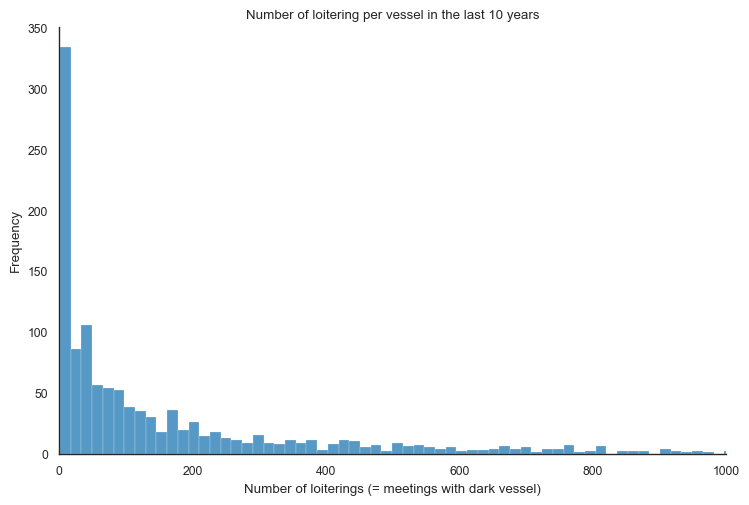

The median is 73.0.


In [ ]:
plot_data = loitering.loc[:,'imo'].value_counts().reset_index()
sns.displot(data=plot_data, x="imo", kind="hist", bins = 300, aspect = 1.5)
plt.xlim(0,1000) 
plt.title('Number of loitering per vessel in the last 10 years')
plt.xlabel('Number of loiterings (= meetings with dark vessel)')
plt.ylabel('Frequency')
plt.show()
print("The median is {median}.".format(median=plot_data['imo'].median()))

Share responsible

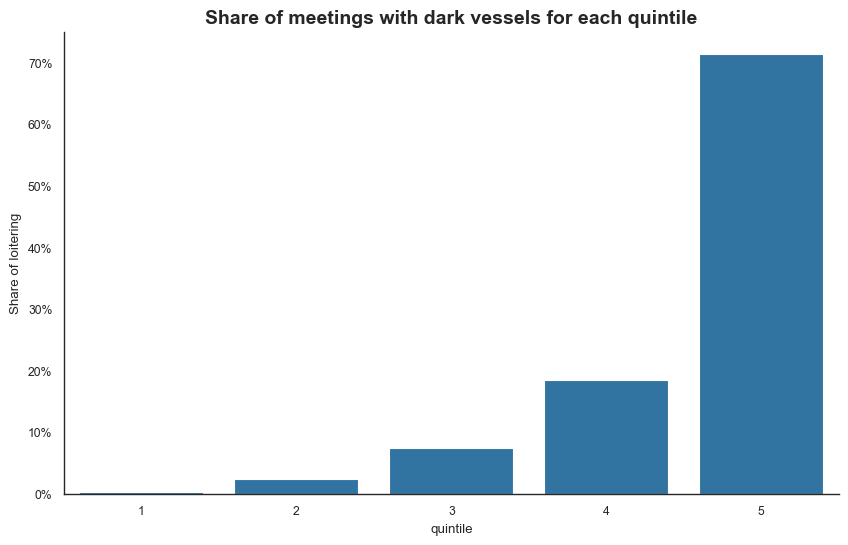

In [ ]:
running_sum = 0
sum = []
share = []
for quintile in range(0,5):
    quantile = (quintile + 1)/5
    amount = plot_data['imo'].quantile(quantile)
    sum.append(plot_data.loc[plot_data['imo']<=amount,'imo'].sum() - running_sum)
    running_sum += sum[-1]
    share.append(sum[-1]/plot_data['imo'].sum() * 100)
quintiles = pd.DataFrame({'quintile' : range(1,6), 'share': share})

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = "quintile",
              y = "share",
              data = quintiles,
              ax = ax,
              color=color)
handles, labels = ax.get_legend_handles_labels()
sns.despine(right = True)
plt.ylabel('Share of loitering')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.title('Share of meetings with dark vessels for each quintile')
ax.set_title('Share of meetings with dark vessels for each quintile',fontdict= { 'fontsize': 14, 'fontweight':'bold'})
plt.savefig(wd + 'port_evaluation/output/quintiles.png', dpi=500)
plt.show()


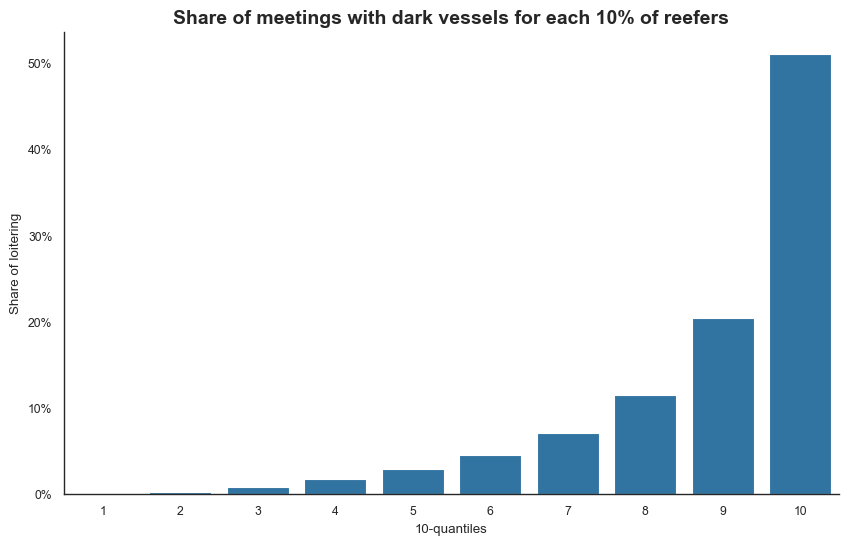

In [ ]:
running_sum = 0
sum = []
share = []
for quintile in range(0,10):
    quantile = (quintile + 1)/10
    amount = plot_data['imo'].quantile(quantile)
    sum.append(plot_data.loc[plot_data['imo']<=amount,'imo'].sum() - running_sum)
    running_sum += sum[-1]
    share.append(sum[-1]/plot_data['imo'].sum() * 100)
quintiles = pd.DataFrame({'10-quantiles' : range(1,11), 'share': share})

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = "10-quantiles",
              y = "share",
              data = quintiles,
              ax = ax,
              color=color)
handles, labels = ax.get_legend_handles_labels()
sns.despine(right = True)
plt.ylabel('Share of loitering')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_title('Share of meetings with dark vessels for each 10% of reefers',fontdict= { 'fontsize': 14, 'fontweight':'bold'})
plt.savefig(wd + 'port_evaluation/output/tenpercent.png', dpi=500)
# plt.title('Share of meetings with dark vessels for each 10% of reefers')
plt.show()

Cutoff for loitering

In [ ]:
plot_data['imo'].quantile(.9)

546.8000000000002

Number of ships

In [ ]:
len(plot_data.loc[plot_data['imo']>=549.49,'imo'])

120

In [ ]:
top_10_percent = plot_data.loc[plot_data['imo']>=549.49,:]
loitering_top = loitering.loc[loitering['imo'].isin(top_10_percent['index']),:]
loitering_top.to_csv(wd + 'port_evaluation/data/proc/GFW/top10percent.csv')

In [ ]:
plot_data2 = top_10_percent.rename({'imo': 'n_dark_meetups'}, axis=1).merge(carriers, how='left', left_on='index', right_on='imo')
plot_data3 = plot_data2.groupby('flag_country')['imo'].nunique().reset_index().sort_values('imo')
# sns.displot(data=plot_data2, x="flag", kind="hist", bins = 300, aspect = 1.5)
# plt.show()

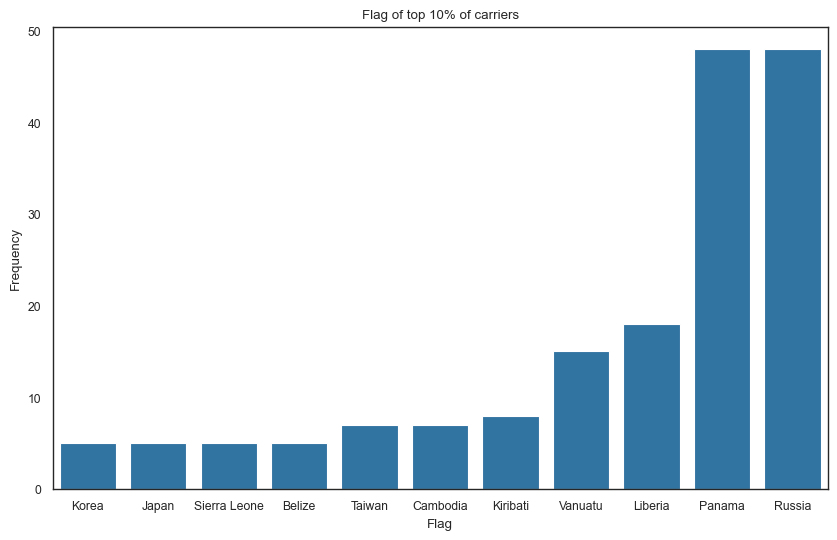

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data3.iloc[21:,:], 
    x='flag_country', 
    y='imo', 
    ax = ax,
    color=color)
plt.title('Flag of top 10% of carriers')
plt.ylabel('Frequency')
plt.xlabel('Flag')
plt.show()

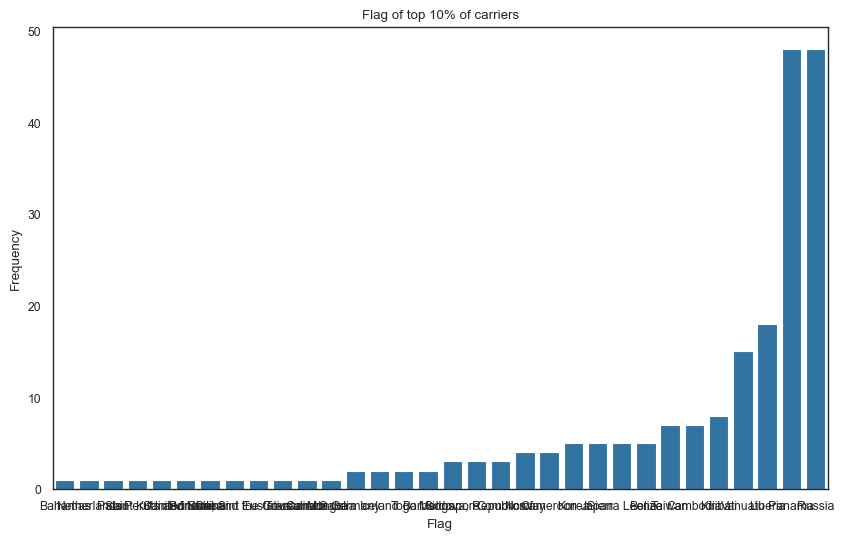

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data3, 
    x='flag_country', 
    y='imo', 
    ax = ax,
    color=color)
plt.title('Flag of top 10% of carriers')
plt.ylabel('Frequency')
plt.xlabel('Flag')
plt.show()

In [ ]:
flags_of_convenience = [
    'Antigua and Barbuda',
    'Bahamas',
    'Barbados',
    'Belize',
    'Bermuda',
    'Bolivia',
    'Cambodia',
    'Cameroon',
    'Cayman Islands',
    'Comoros',
    'Cook Islands',
    'Curacao',
    'Cyprus',
    'Equatorial Guinea',
    'Faroe Islands',
    'Georgia',
    'Gibraltar',
    'Honduras',
    'Jamaica',
    'Lebanon',
    'Liberia',
    'Malta',
    'Madeira',
    'Marshall Islands',
    'Mauritius',
    'Moldova',
    'Mongolia',
    'Myanmar',
    "Korea, Democratic People's Republic of",
    'Palau',
    'Panama',
    'Sao Tome and Príncipe',
    'Sierra Leone',
    'Saint Kitts and Nevis',
    'Saint Vincent',
    'Sri Lanka',
    'Tanzania',
    'Togo',
    'Tonga',
    'Vanuatu'
]
flags_of_con = []
for country_name in flags_of_convenience:
    flags_of_con.append(pycountry.countries.search_fuzzy(country_name)[0].alpha_3)

In [ ]:
loitering['imo'].nunique()
loitering['flag'].unique()
flags = loitering \
    .groupby('flag')['imo'] \
    .nunique() \
    .reset_index() \
    .sort_values('imo',ascending=False)
flags['con'] = flags['flag'].isin(flags_of_con) * 1
flags

,flag,imo,con
56,PAN,370,1
61,RUS,261,0
3,BHS,134,1
41,LBR,122,1
10,CHN,57,0
...,...,...,...
33,IRN,1,0
25,FSM,1,0
1,AUS,0,0
23,FJI,0,0


In [ ]:
flags.loc[flags['con']==1,'imo'].sum()

1016

In [ ]:
flags.loc[flags['con']==0,'imo'].sum()

671

In [ ]:
flags.loc[flags['con']==0,:]

,flag,imo,con
61,RUS,261,0
10,CHN,57,0
40,KOR,53,0
38,KIR,47,0
54,NOR,34,0
2,BES,28,0
77,USA,25,0
70,THA,23,0
58,PHL,17,0
64,SGP,16,0


Time

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_81035/1922207913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loitering_top['start_dt'] = pd.to_datetime(loitering_top['start'])
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_81035/1922207913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loitering_top['year'] = loitering_top['start_dt'].dt.year


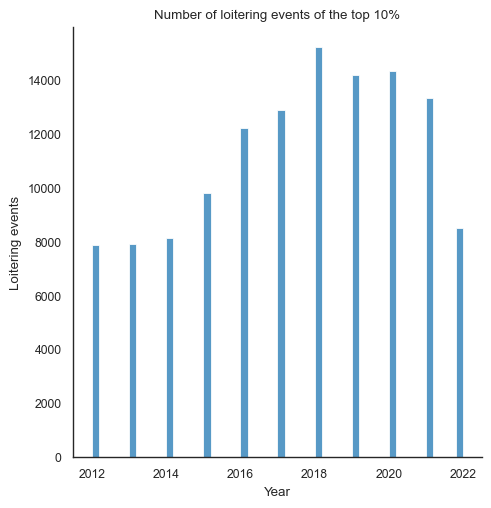

In [ ]:
loitering_top['start_dt'] = pd.to_datetime(loitering_top['start'])
loitering_top['year'] = loitering_top['start_dt'].dt.year
sns.displot(data=loitering_top, x="year", kind="hist")
plt.title('Number of loitering events of the top 10%')
plt.ylabel('Loitering events')
plt.xlabel('Year')
plt.show()

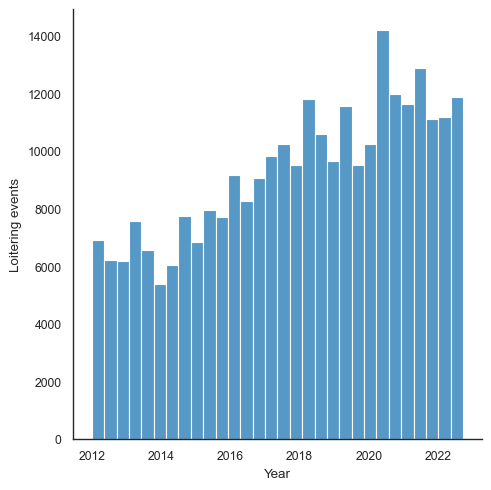

In [ ]:
loitering['start_dt'] = pd.to_datetime(loitering['start'])
loitering['year'] = loitering['start_dt'].dt.year
# plot_data5 = loitering.loc[loitering['start']>='2012-03-01', :]
# plot_data5 = plot_data5.loc[plot_data5['start']<='2022-01-01', :]
sns.displot(data=loitering, x="start_dt", kind="hist", bins=30)
# plt.title('Number of loitering events')
plt.ylabel('Loitering events')
plt.xlabel('Year')
ax.set_title('Meet-ups with dark vessels',fontdict= { 'fontsize': 14, 'fontweight':'bold'})
plt.savefig(wd + 'port_evaluation/output/distribution.png', dpi=500)
# plt.xlim(pd.to_datetime('2012-03-01'), pd.to_datetime('2022-05-01'))
plt.show()

Additional analysis:

- which boats they each encountered
- length and size (using SeaVision)

## Location of meetups

EEZ

In [ ]:
loiter2['averageDistanceFromShorenm'] = loiter2['averageDistanceFromShoreKm'] / 1.852

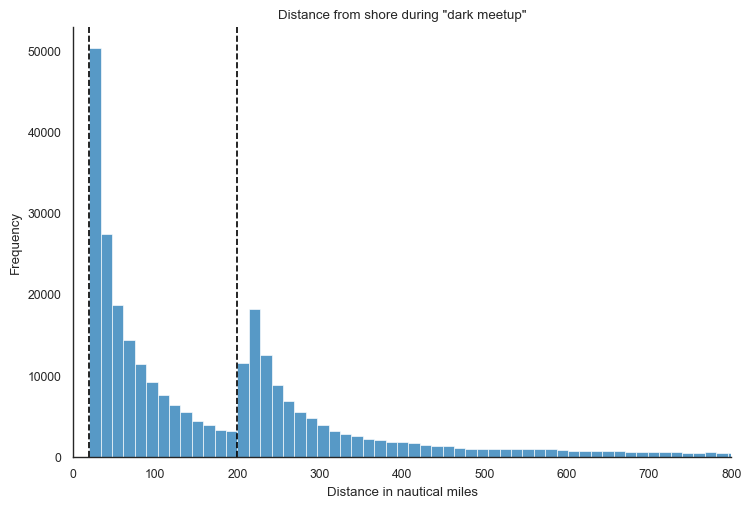

In [ ]:
fig = sns.displot(data=loiter2, x="averageDistanceFromShorenm", kind="hist", bins = 100, aspect = 1.5)
plt.axvline(200,c='black',linestyle='--')
plt.axvline(20,c='black',linestyle='--')
plt.xlim(0,800) 
plt.title('Distance from shore during "dark meetup"')
plt.xlabel('Distance in nautical miles')
plt.ylabel('Frequency')
plt.show()

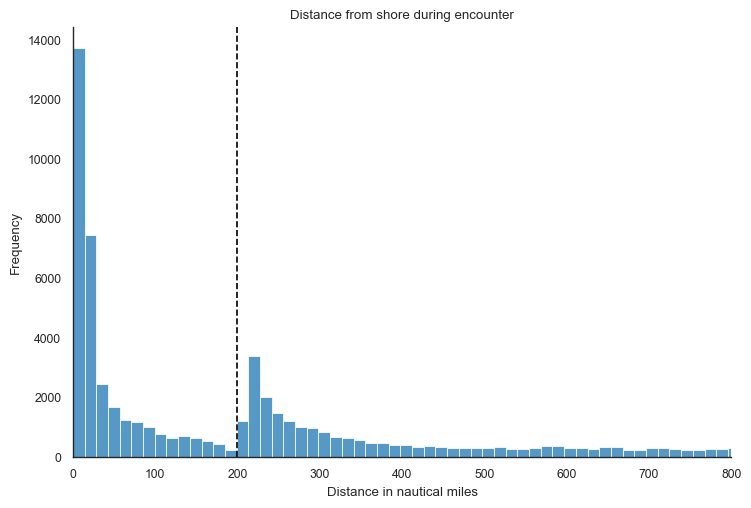

In [31]:
fig = sns.displot(data=encounter, x="distance_from_shore_nm", kind="hist", bins = 80, aspect = 1.5) #, row='encounter.authorization_status')
plt.axvline(200,c='black',linestyle='--')
# plt.axvline(20,c='black',linestyle='--')
plt.xlim(0,800) 
plt.title('Distance from shore during encounter')
plt.xlabel('Distance in nautical miles')
plt.ylabel('Frequency')
plt.savefig(wd + 'port_evaluation/output/encounter_from_shore.png')
plt.show()

/Users/sebastiandodt/opt/miniconda3/envs/capstoneenv/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


TypeError: 'FacetGrid' object is not callable

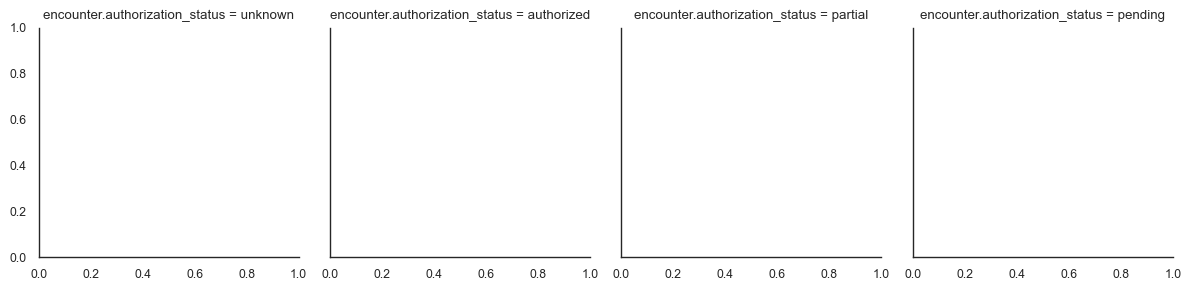

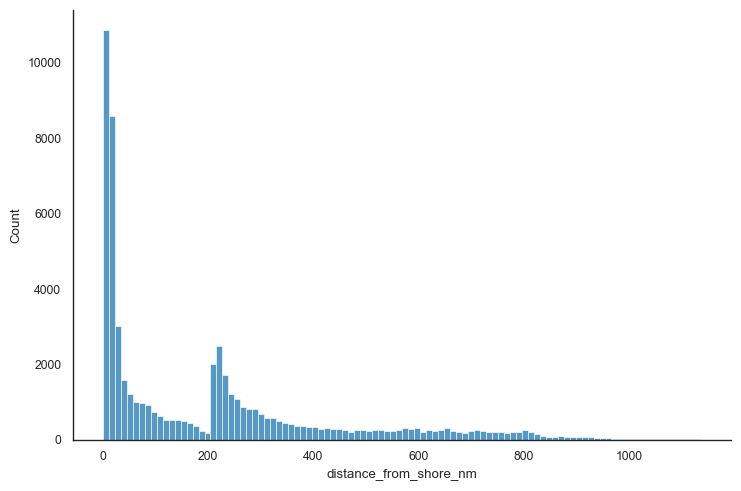

In [26]:
g = sns.FacetGrid(encounter, col="encounter.authorization_status")
g.map(sns.displot(data=encounter, x="distance_from_shore_nm", kind="hist", bins = 100, aspect = 1.5))
# plt.axvline(200,c='black',linestyle='--')
# # plt.axvline(20,c='black',linestyle='--')
# plt.xlim(0,800) 
# plt.title('Distance from shore during "dark meetup"')
# plt.xlabel('Distance in nautical miles')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
loiter2['eez'].isna().sum()/len(loiter2)

0.4099862088475547

40% of dark meet-ups in EEZ

In [ ]:
test_data = loiter2.groupby('eez')['event_id'].nunique().reset_index().sort_values('event_id')
test_data.set_index(test_data.columns.drop('eez',1) \
    .tolist()) \
    .eez.str.split(',', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'eez'}) \
    .loc[:, test_data.columns]

,eez,event_id
0,33185,1
1,8334,1
2,48972,1
3,8309,1
4,26526,1
...,...,...
282,48950,3735
283,8492,4597
284,5686,4798
285,8487,7345


In [ ]:
loiter2.columns

Index(['event_id', 'event_type', 'event_start', 'event_end', 'event_lat',
       'event_lon', 'mpa', 'eez', 'rfmo', 'fao', 'major_fao', 'eez12nm',
       'boundingBox', 'startDistanceFromShoreKm', 'endDistanceFromShoreKm',
       'startDistanceFromPortKm', 'endDistanceFromPortKm', 'vessel_id', 'flag',
       'vessel_name', 'vessel_type', 'vessel_ssvid', 'totalTimeHours',
       'totalDistanceKm', 'averageSpeedKnots', 'averageDistanceFromShoreKm',
       'averageDistanceFromShorenm'],
      dtype='object')

In [ ]:
# loiter2 = loiter2.loc[loiter2['event_start'].dt.year >=2019,:]
plot_data4 = loiter2.groupby('eez')['event_id'].nunique().reset_index().sort_values('event_id')
plot_data4 = plot_data4 \
    .set_index(plot_data4.columns.drop('eez',1).tolist()) \
    .eez.str.split(',', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'eez'}) \
    .loc[:, plot_data4.columns] \

plot_data4['eez'] = plot_data4['eez'].replace(' ','')

plot_data4 = plot_data4 \
    .groupby('eez')['event_id'] \
    .sum() \
    .reset_index() \
    .sort_values('event_id')

In [ ]:
eez_data['MRGID_new'] = eez_data['MRGID'].astype(str)

In [ ]:
plot_data4 = plot_data4.merge(eez_data, left_on='eez', right_on='MRGID_new', how='left').reset_index(drop=True)

In [ ]:
additional = {
    '8487': 'Japanese Exclusive Economic Zone',
    '8492': 'Indonesian Exclusive Economic Zone',
    '48950': 'Kuril Islands (Japan v. Russia)',
    '8471': 'Guinea Bissau Exclusive Economic Zone',
    '8463': 'United States Exclusive Economic Zone (Alaska)',
    '8488': 'Kiribati Exclusive Economic Zone',
    '8486': 'Chinese Exclusive Economic Zone',
    '8493': 'Canadian Exclusive Economic Zone',
}
for eez in additional.keys():
    plot_data4.loc[plot_data4['eez']==eez, 'preferredGazetteerName'] = additional[eez]
# for row in range(len(plot_data4)):
plot_data4['preferredGazetteerName'] = \
    plot_data4['preferredGazetteerName'] \
        .str.replace('Exclusive Economic Zone', 'EEZ')
plot_data4['preferredGazetteerName'] = \
    plot_data4['preferredGazetteerName'] \
        .str.replace('Exclusive economic Zone', 'EEZ')

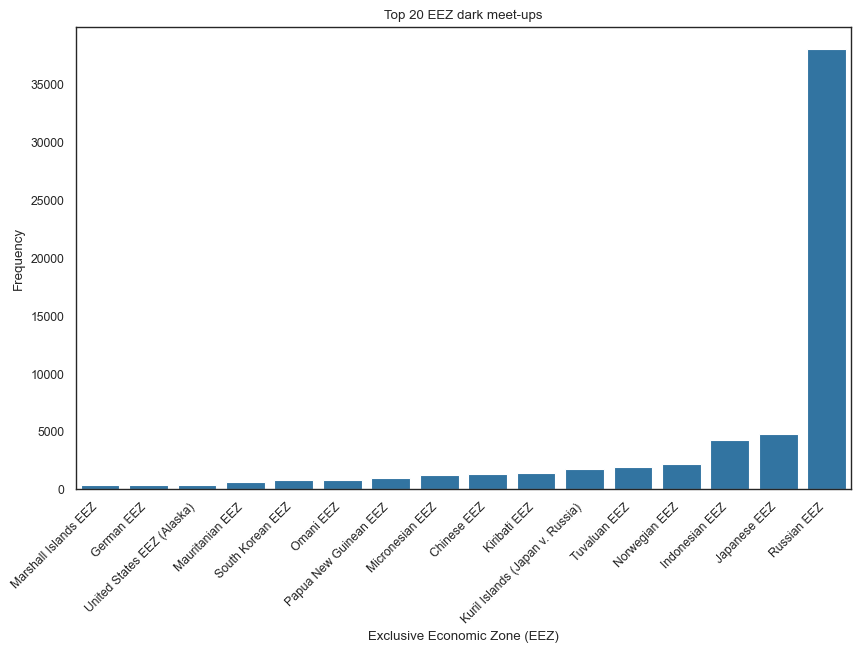

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data4.iloc[-20:,:], 
    x='preferredGazetteerName', 
    y='event_id', 
    ax = ax,
    color=color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Top 20 EEZ dark meet-ups')
plt.ylabel('Frequency')
plt.xlabel('Exclusive Economic Zone (EEZ)')
plt.show()

In [ ]:
# plot_data4 = plot_data4 \
#     .rename({'event_id': 'number_of_loitering'}, axis=1) \
#     .sort_values('number_of_loitering')

# plot_data4[['MRGID', 'number_of_loitering', 'latitude', 'longitude', 'preferredGazetteerName']] \
#     .to_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/output/eunyoung/loitering_by_eez_3_year_sum.csv',
#     index=False)

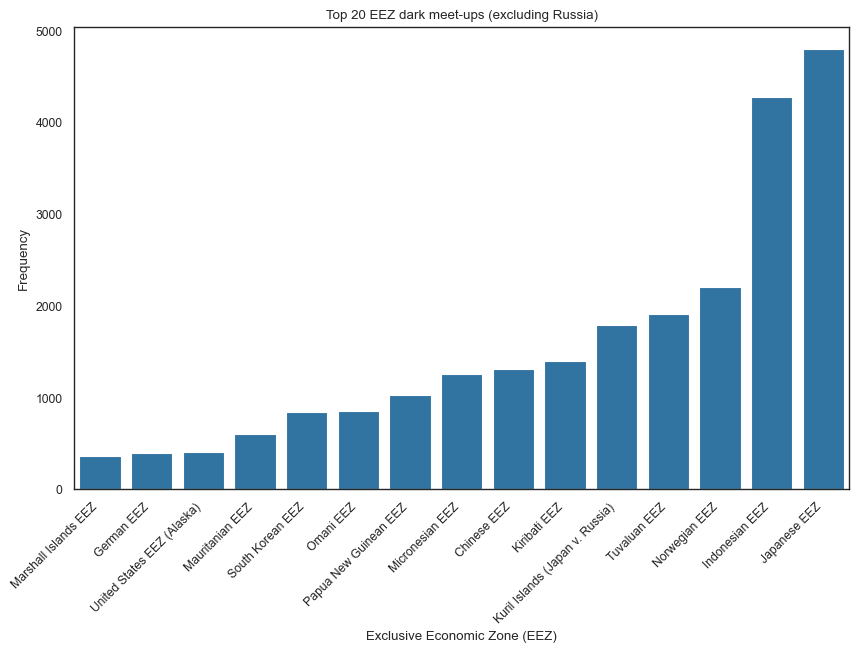

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data4.iloc[-20:-1,:], 
    x='preferredGazetteerName', 
    y='event_id', 
    ax = ax,
    color=color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Top 20 EEZ dark meet-ups (excluding Russia)')
plt.ylabel('Frequency')
plt.xlabel('Exclusive Economic Zone (EEZ)')
plt.show()

RFMOs

In [ ]:
 ## for Dylan: add 'event_id' to all groupby's
plot_data5 = loitering \
    .rename({'regions.rfmo': 'rfmo'}, axis=1) \
    .groupby('rfmo')['id_loitering'] \
    .nunique() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5 = plot_data5.set_index(plot_data5.columns.drop('rfmo',1).tolist()) \
    .rfmo.str.split(',', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'rfmo'}) \
    .loc[:, plot_data5.columns] \
    .groupby('rfmo')['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5 = plot_data5.set_index(plot_data5.columns.drop('rfmo',1).tolist()) \
    .rfmo.str.split('|', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'rfmo'}) \
    .loc[:, plot_data5.columns] \
    .groupby('rfmo')['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5['rfmo'] = plot_data5['rfmo'].str.replace(' ','')
plot_data5 = plot_data5 \
    .groupby('rfmo')['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')  


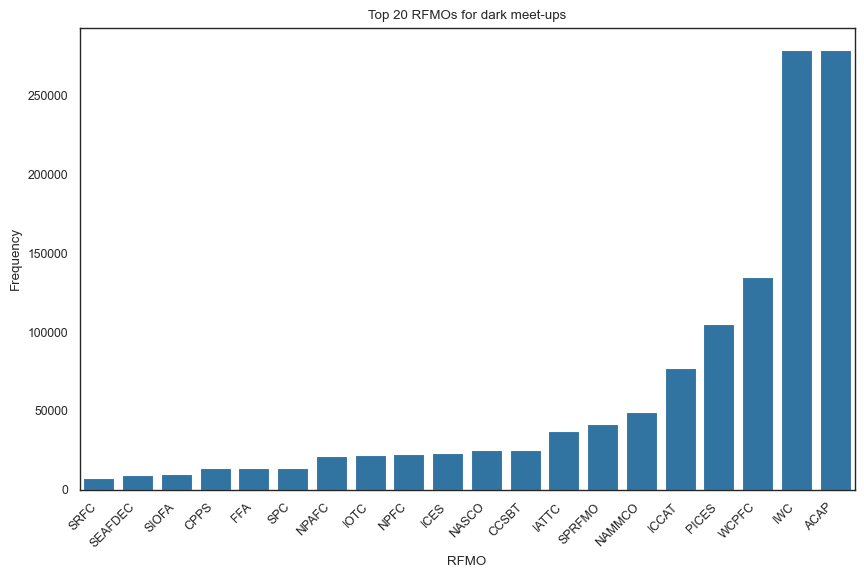

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data5.iloc[-20:,:], 
    x='rfmo', 
    y='id_loitering', 
    ax = ax,
    color=color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Top 20 RFMOs for dark meet-ups')
plt.ylabel('Frequency')
plt.xlabel('RFMO')
plt.show()

In [ ]:
plot_data5['loit_share'] = 100*plot_data5['id_loitering']/len(loitering)

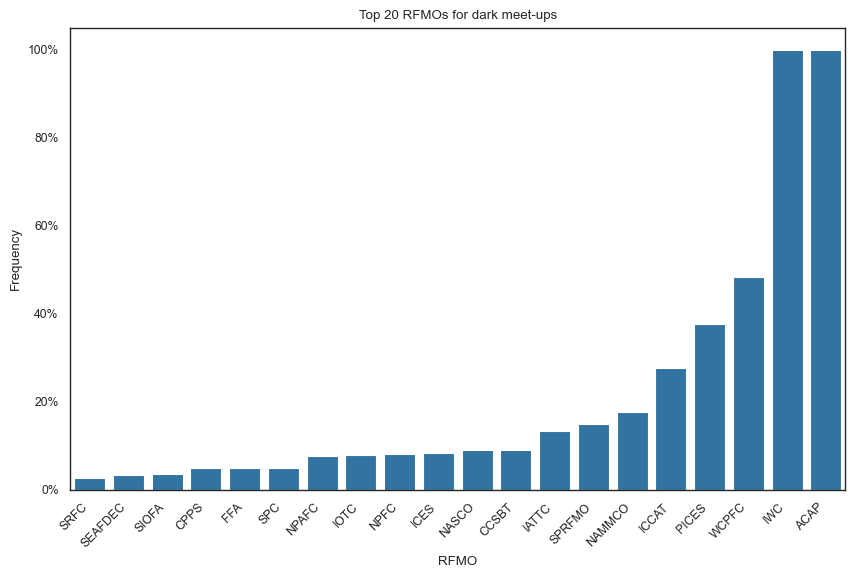

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data5.iloc[-20:,:], 
    x='rfmo', 
    y='loit_share', 
    ax = ax,
    color=color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Top 20 RFMOs for dark meet-ups')
plt.ylabel('Frequency')
plt.xlabel('RFMO')
plt.show()

In [ ]:
loiter2['months_since_jan_2012'] = (loiter2['event_start'].dt.year - 2012) * 12 + loiter2['event_start'].dt.month - 1
plot_data6 = loiter2.groupby(['eez', 'months_since_jan_2012'])['event_id'].nunique().reset_index().sort_values('event_id')
plot_data6 = plot_data6.set_index(plot_data6.columns.drop('eez',1).tolist()) \
    .eez.str.split(',', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'eez'}) \
    .loc[:, plot_data6.columns] \
    .groupby(['eez', 'months_since_jan_2012'])['event_id'] \
    .sum() \
    .reset_index() \
    .sort_values('event_id')
print(eez_data)
plot_data6 = plot_data6.merge(eez_data, left_on='eez', right_on='MRGID_new', how='left').reset_index(drop=True)
plot_data6 = pd.concat([plot_data6.loc[plot_data6['eez']=='8371',:], plot_data6.loc[plot_data6['eez']==' 8371',:]], ignore_index=True)
plot_data6 = plot_data6.groupby('months_since_jan_2012')['event_id'].sum().reset_index()
plot_data6['months_since_jan_2012'] -= 77
plot_data6['years_since_operation'] = plot_data6['months_since_jan_2012'] // 12 + 1

    MRGID                                    gazetteerSource placeType  \
0    3293  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
1    5668  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
2    5669  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
3    5670  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
4    5672  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
..    ...                                                ...       ...   
95   8374  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
96   8375  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
97   8376  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
98   8378  Flanders Marine Institute (2019). Maritime Bou...       EEZ   
99   8379  Flanders Marine Institute (2019). Maritime Bou...       EEZ   

    latitude  longitude  minLatitude  minLongitude  maxLatitude  maxLongitude  \
0   51.46545    2.70504     51

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_81035/4134111955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loiter2['months_since_jan_2012'] = (loiter2['event_start'].dt.year - 2012) * 12 + loiter2['event_start'].dt.month - 1


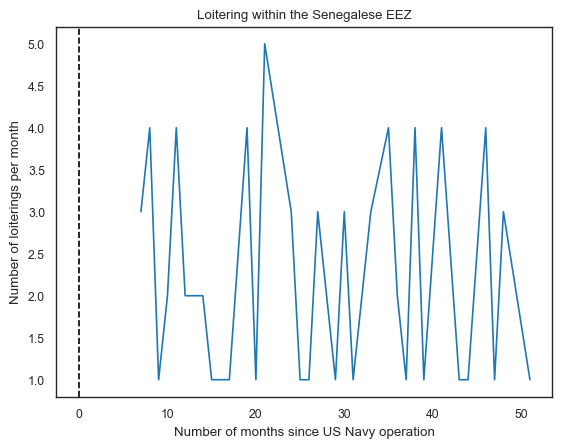

In [ ]:
sns.lineplot(plot_data6, x='months_since_jan_2012', y='event_id')
plt.axvline(0,c='black',linestyle='--')
plt.title("Loitering within the Senegalese EEZ")
plt.ylabel("Number of loiterings per month")
plt.xlabel("Number of months since US Navy operation")
plt.savefig(wd + 'port_evaluation/output/senegal.png', dpi=500)
plt.show()

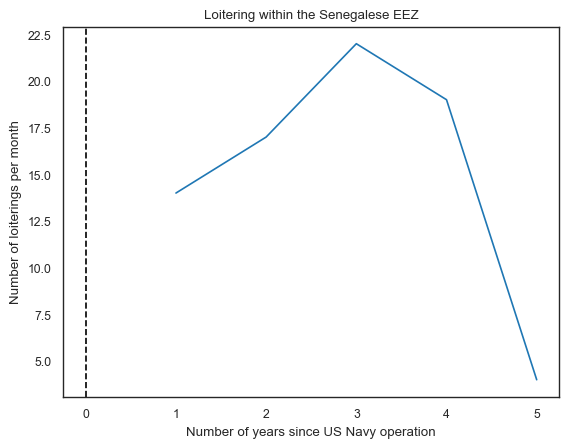

In [ ]:
plot_data6 = plot_data6.groupby('years_since_operation')['event_id'].sum().reset_index()
sns.lineplot(plot_data6, x='years_since_operation', y='event_id')
plt.axvline(0,c='black',linestyle='--')
plt.title("Loitering within the Senegalese EEZ")
plt.ylabel("Number of loiterings per month")
plt.xlabel("Number of years since US Navy operation")
plt.savefig(wd + 'port_evaluation/output/senegal_yearly.png', dpi=500)
plt.show()

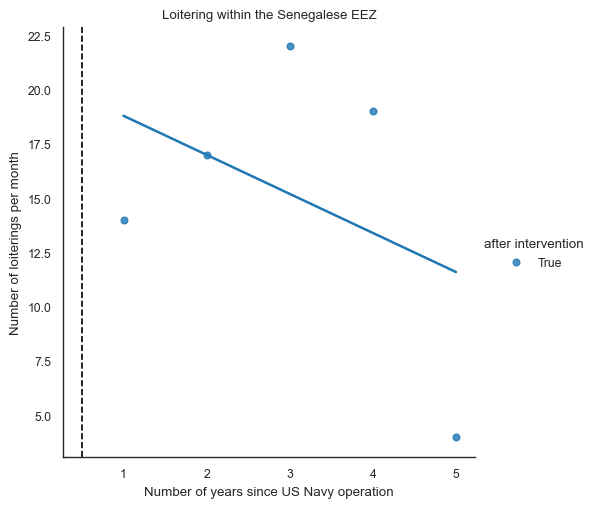

In [ ]:
plot_data6 = plot_data6.groupby('years_since_operation')['event_id'].sum().reset_index()
plot_data6['after intervention'] = plot_data6['years_since_operation'] > 0
sns.lmplot(plot_data6, x='years_since_operation', y='event_id', hue='after intervention', ci=None)
plt.axvline(0.5,c='black',linestyle='--')
plt.title("Loitering within the Senegalese EEZ")
plt.ylabel("Number of loiterings per month")
plt.xlabel("Number of years since US Navy operation")
plt.savefig(wd + 'port_evaluation/output/senegal_rd.png', dpi=500)
plt.show()

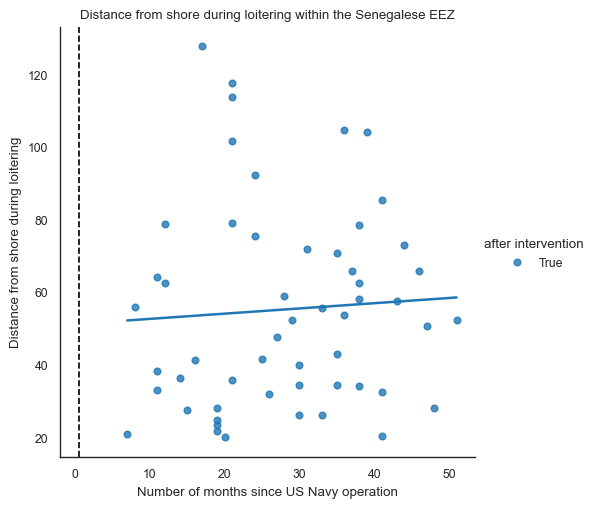

In [ ]:
plot_data7 = loiter2.copy()
plot_data7 = pd.concat([plot_data7.loc[plot_data7['eez']=='8371',:], plot_data7.loc[plot_data7['eez']==' 8371',:]], ignore_index=True)
plot_data7['months_since_jun_2018'] = plot_data7['months_since_jan_2012'] - 77
plot_data7['after intervention'] = plot_data7['months_since_jun_2018'] > 0
plot_data7 = plot_data7.loc[plot_data7['months_since_jun_2018'] >= -60,:]
plot_data7 = plot_data7.loc[plot_data7['months_since_jun_2018'] <= 60,:]
sns.lmplot(plot_data7, x='months_since_jun_2018', y='averageDistanceFromShorenm', hue='after intervention', ci=None)
plt.axvline(0.5,c='black',linestyle='--')
plt.title("Distance from shore during loitering within the Senegalese EEZ")
plt.ylabel("Distance from shore during loitering")
plt.xlabel("Number of months since US Navy operation")
plt.savefig(wd + 'port_evaluation/output/senegal_rd_distance_from_shore.png', dpi=500)
plt.show()

In [ ]:
loiter2['months_since_jan_2012']

158600     84
158601     84
158602     84
158603     84
158604     84
         ... 
282785    129
282786    129
282787    129
282788    129
282789    129
Name: months_since_jan_2012, Length: 124190, dtype: int64

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_81035/3183325311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loiter2['within eez'] = loiter2['eez'].notna()
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_81035/3183325311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loiter2['year'] = loiter2['event_start'].dt.year


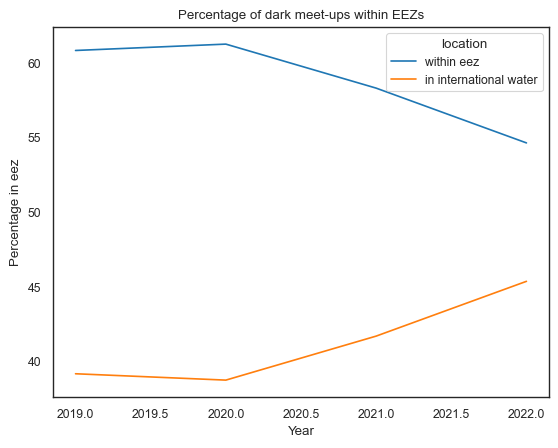

In [ ]:
loiter2['within eez'] = loiter2['eez'].notna()
loiter2['year'] = loiter2['event_start'].dt.year
plot_data8 = loiter2.groupby('year')['within eez'].mean().reset_index()
plot_data8['within eez'] *= 100
plot_data8['in international water'] = 100 - plot_data8['within eez']
plot_data8 = pd.melt(plot_data8, id_vars='year', value_vars=['within eez', 'in international water'])
plot_data8.columns = ['year', 'location', 'value']
sns.lineplot(plot_data8, x='year', y='value', hue='location')
plt.title('Percentage of dark meet-ups within EEZs')
plt.xlabel('Year')
plt.ylabel('Percentage in eez')
plt.savefig(wd + 'port_evaluation/output/perc_in_eez.png', dpi=500)
plt.show()

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_81035/2224248976.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loiter2['within eez'] = loiter2['eez'].notna()
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_81035/2224248976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loiter2['year'] = loiter2['event_start'].dt.year


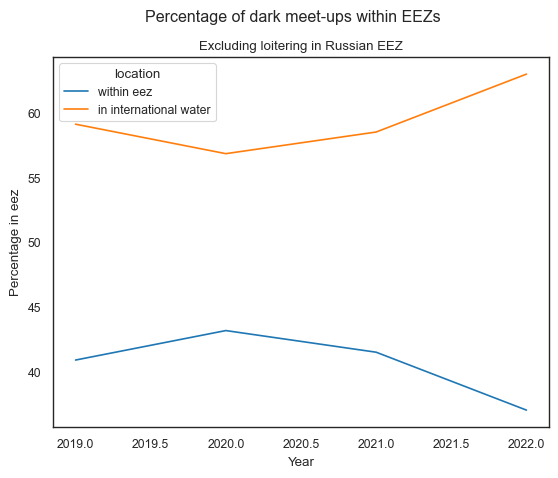

5690

In [ ]:

loiter2['within eez'] = loiter2['eez'].notna()
loiter2['year'] = loiter2['event_start'].dt.year
plot_data9 = loiter2.loc[loiter2['eez']!='5690',:]
plot_data9 = plot_data9.groupby('year')['within eez'].mean().reset_index()
plot_data9['within eez'] *= 100
plot_data9['in international water'] = 100 - plot_data9['within eez']
plot_data9 = pd.melt(plot_data9, id_vars='year', value_vars=['within eez', 'in international water'])
plot_data9.columns = ['year', 'location', 'value']
sns.lineplot(plot_data9, x='year', y='value', hue='location')
plt.suptitle('Percentage of dark meet-ups within EEZs')
plt.title("Excluding loitering in Russian EEZ")
plt.xlabel('Year')
plt.ylabel('Percentage in eez')
plt.savefig(wd + 'port_evaluation/output/perc_in_eez_no_russia.png', dpi=500)
plt.show()
5690    

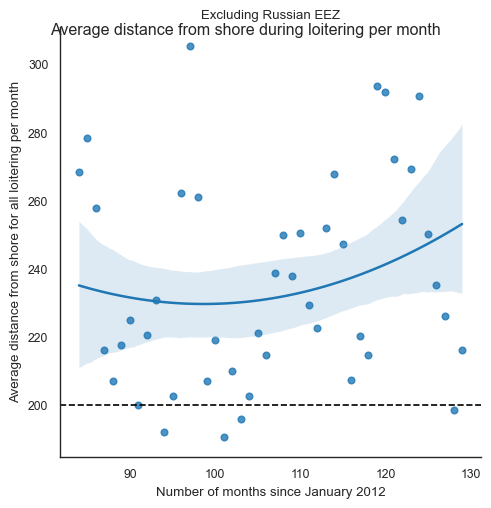

In [ ]:
plot_data10 = loiter2.copy()
plot_data10 = plot_data10.loc[plot_data10['eez']!='5690',:]
plot_data10 = plot_data10.groupby('months_since_jan_2012')['averageDistanceFromShorenm'].mean().reset_index()
sns.lmplot(plot_data10, x='months_since_jan_2012', y='averageDistanceFromShorenm', ci=90, order=2)
# plt.axvline(0.5,c='black',linestyle='--')
plt.axhline(200,c='black',linestyle='--')
plt.title("Excluding Russian EEZ")
plt.suptitle("Average distance from shore during loitering per month")
plt.ylabel("Average distance from shore for all loitering per month")
plt.xlabel("Number of months since January 2012")
plt.savefig(wd + 'port_evaluation/output/distance_from_shore_over_time.png', dpi=500)
plt.show()

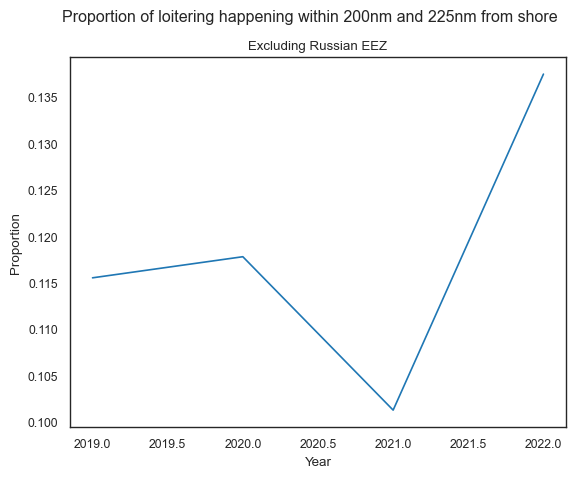

In [ ]:
plot_data10 = loiter2.copy()
plot_data10 = plot_data10.loc[plot_data10['eez']!='5690',:]
plot_data10['juuuust outside eez'] = (plot_data10['averageDistanceFromShorenm'] >= 200) & (plot_data10['averageDistanceFromShorenm'] <= 225)
plot_data10 = plot_data10.groupby('year')['juuuust outside eez'].mean().reset_index()
# plot_data10 = 
sns.lineplot(plot_data10, x='year', y='juuuust outside eez')
# plt.axvline(0.5,c='black',linestyle='--')
# plt.axhline(200,c='black',linestyle='--')
plt.title("Excluding Russian EEZ")
plt.suptitle("Proportion of loitering happening within 200nm and 225nm from shore")
plt.ylabel("Proportion")
plt.xlabel("Year")
plt.savefig(wd + 'port_evaluation/output/suspicious_place.png', dpi=500)
plt.show()

In [ ]:
iccat = pd.read_excel('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/rfmo/RFMO.xlsx',
    sheet_name='ICCAT')
iotc = pd.read_excel('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/rfmo/RFMO.xlsx',
    sheet_name='IOTC')
iattc = pd.read_excel('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/rfmo/RFMO.xlsx',
    sheet_name='IATTC')
# loitering_unified = pd.read_csv('/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/pipeline/data/unified/loitering.csv')

In [ ]:
loitering['months_since_jan_2012'] = (pd.to_datetime(loitering['start']).dt.year - 2012) * 12 + pd.to_datetime(loitering['start']).dt.month - 1

In [ ]:
plot_data5 = loitering \
    .rename({'regions.rfmo': 'rfmo'}, axis=1) \
    .groupby(['rfmo','flag','months_since_jan_2012'])['id_loitering'] \
    .nunique() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5 = plot_data5.set_index(plot_data5.columns.drop('rfmo',1).tolist()) \
    .rfmo.str.split(',', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'rfmo'}) \
    .loc[:, plot_data5.columns] \
    .groupby(['rfmo','flag','months_since_jan_2012'])['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5 = plot_data5.set_index(plot_data5.columns.drop('rfmo',1).tolist()) \
    .rfmo.str.split('|', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'rfmo'}) \
    .loc[:, plot_data5.columns] \
    .groupby(['rfmo','flag','months_since_jan_2012'])['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5['rfmo'] = plot_data5['rfmo'].str.replace(' ','')
plot_data5 = plot_data5 \
    .groupby(['rfmo','flag','months_since_jan_2012'])['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')  
plot_data5a = plot_data5.copy()
plot_data5b = plot_data5.copy()

In [ ]:
plot_data5 = plot_data5.loc[plot_data5['rfmo']=='ICCAT',:]
plot_data5 = plot_data5.merge(iccat, how='inner', left_on='flag', right_on='ISO')
plot_data5['adh_months_since_jan_2012'] = (pd.to_datetime(plot_data5['Year of adhesion']).dt.year - 2012) * 12 + pd.to_datetime(plot_data5['Year of adhesion']).dt.month - 1
plot_data5['months_since_adhesion'] = plot_data5['months_since_jan_2012'] - plot_data5['adh_months_since_jan_2012']


In [ ]:
plot_data5 = plot_data5.loc[plot_data5['flag']=='LBR',:]
plot_data5['years_after_adhesion'] = plot_data5['months_since_adhesion'] // 12 + 1
plot_data5['after_adhesion'] = plot_data5['years_after_adhesion'] > 0

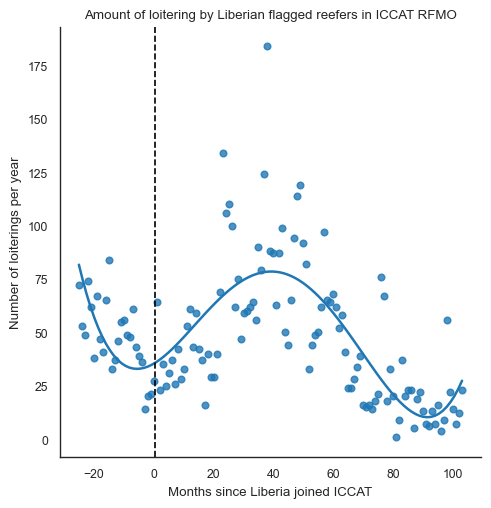

In [ ]:
sns.lmplot(plot_data5, x='months_since_adhesion', y='id_loitering', order=4, ci=None)
plt.axvline(0.5,c='black',linestyle='--')
plt.title('Amount of loitering by Liberian flagged reefers in ICCAT RFMO')
plt.xlabel('Months since Liberia joined ICCAT')
plt.ylabel('Number of loiterings per year')
plt.savefig(wd + 'port_evaluation/output/eunyoung/iccat_monthly.png', dpi=500)
plt.show()

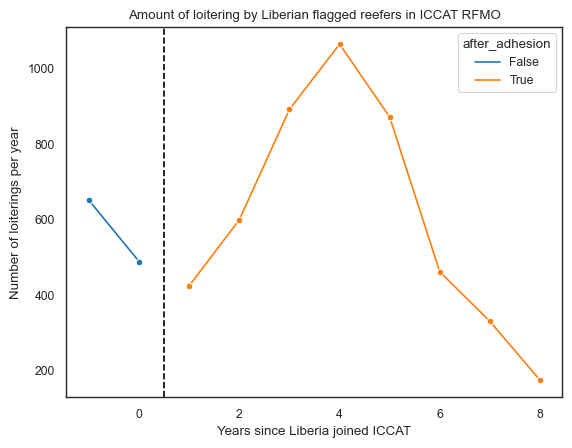

In [ ]:
plot_data5 = plot_data5.groupby('years_after_adhesion')['id_loitering'].sum().reset_index()
plot_data5['after_adhesion'] = plot_data5['years_after_adhesion'] > 0
plot_data5 = plot_data5.loc[plot_data5['years_after_adhesion']>min(plot_data5['years_after_adhesion']),:]
plot_data5 = plot_data5.loc[plot_data5['years_after_adhesion']<max(plot_data5['years_after_adhesion']),:]
sns.lineplot(plot_data5, x='years_after_adhesion', y='id_loitering', hue='after_adhesion', marker="o")
plt.axvline(0.5,c='black',linestyle='--')
plt.title('Amount of loitering by Liberian flagged reefers in ICCAT RFMO')
plt.xlabel('Years since Liberia joined ICCAT')
plt.ylabel('Number of loiterings per year')
plt.savefig(wd + 'port_evaluation/output/eunyoung/iccat.png', dpi=500)
plt.show()

IOTC

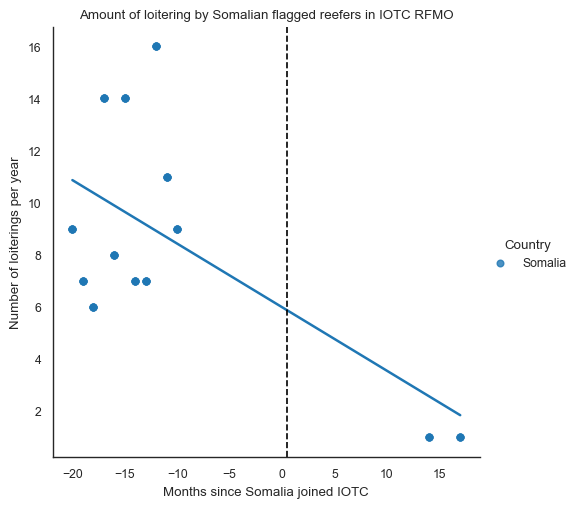

In [ ]:
iotc = iotc.loc[iotc['Date of acceptance']>='2014-03-01',:]
plot_data5a = plot_data5a.loc[plot_data5a['flag']=='SOM',:]
plot_data5 = plot_data5a.merge(iotc, how='inner', left_on='flag', right_on='ISO')
plot_data5['adh_months_since_jan_2012'] = (pd.to_datetime(plot_data5['Date of acceptance']).dt.year - 2012) * 12 + pd.to_datetime(plot_data5['Date of acceptance']).dt.month - 1
plot_data5['months_since_adhesion'] = plot_data5['months_since_jan_2012'] - plot_data5['adh_months_since_jan_2012']
plot_data5['years_after_adhesion'] = plot_data5['months_since_adhesion'] // 12 + 1
plot_data5['after_adhesion'] = plot_data5['years_after_adhesion'] > 0
sns.lmplot(plot_data5, x='months_since_adhesion', y='id_loitering', hue='Country', ci=None)
plt.axvline(0.5,c='black',linestyle='--')
plt.title('Amount of loitering by Somalian flagged reefers in IOTC RFMO')
plt.xlabel('Months since Somalia joined IOTC')
plt.ylabel('Number of loiterings per year')
plt.savefig(wd + 'port_evaluation/output/eunyoung/iotc.png', dpi=500)
plt.show()

IATTC

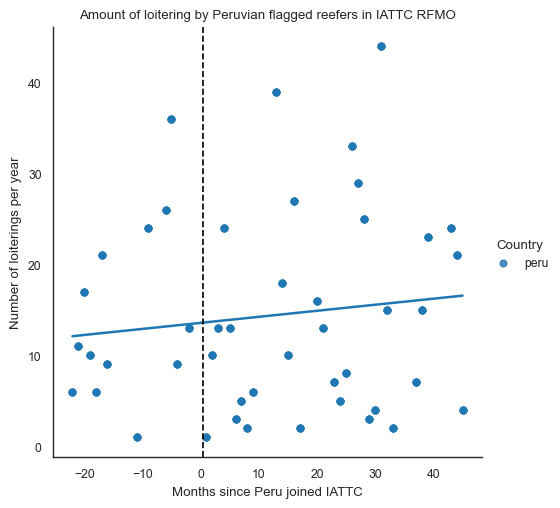

In [ ]:
iattc = iattc.loc[iattc['ISO']=='PER',:]
# plot_data5a = plot_data5a.loc[plot_data5a['flag']=='SOM',:]
plot_data5 = plot_data5b.merge(iattc, how='inner', left_on='flag', right_on='ISO')
plot_data5['adh_months_since_jan_2012'] = (pd.to_datetime(plot_data5['ratification']).dt.year - 2012) * 12 + pd.to_datetime(plot_data5['ratification']).dt.month - 1
plot_data5['months_since_adhesion'] = plot_data5['months_since_jan_2012'] - plot_data5['adh_months_since_jan_2012']
plot_data5['years_after_adhesion'] = plot_data5['months_since_adhesion'] // 12 + 1
plot_data5['after_adhesion'] = plot_data5['years_after_adhesion'] > 0

sns.lmplot(plot_data5, x='months_since_adhesion', y='id_loitering', hue='Country', ci=None)
plt.axvline(0.5,c='black',linestyle='--')
plt.title('Amount of loitering by Peruvian flagged reefers in IATTC RFMO')
plt.xlabel('Months since Peru joined IATTC')
plt.ylabel('Number of loiterings per year')
plt.savefig(wd + 'port_evaluation/output/eunyoung/iattc.png', dpi=500)
plt.show()

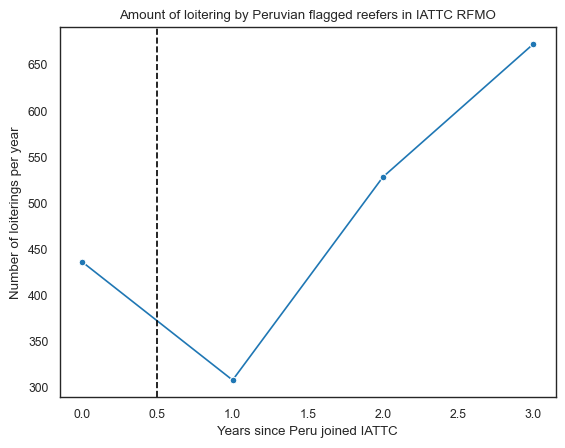

In [ ]:
plot_data5 = plot_data5.groupby('years_after_adhesion')['id_loitering'].sum().reset_index()
plot_data5['after_adhesion'] = plot_data5['years_after_adhesion'] > 0
plot_data5 = plot_data5.loc[plot_data5['years_after_adhesion']>min(plot_data5['years_after_adhesion']),:]
plot_data5 = plot_data5.loc[plot_data5['years_after_adhesion']<max(plot_data5['years_after_adhesion']),:]
sns.lineplot(plot_data5, x='years_after_adhesion', y='id_loitering', marker="o")
plt.axvline(0.5,c='black',linestyle='--')
plt.title('Amount of loitering by Peruvian flagged reefers in IATTC RFMO')
plt.xlabel('Years since Peru joined IATTC')
plt.ylabel('Number of loiterings per year')
plt.savefig(wd + 'port_evaluation/output/eunyoung/iattc_yearly.png', dpi=500)
plt.show()